In [1]:
# Install pytorch and tqdm (if necessary)
!pip install torch
!pip install torchvision
!pip install tqdm

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Handle imports

import math
import os
import datetime
import csv
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import tqdm

from IPython import display

In [3]:
# The Args object will contain all of our parameters
# If you want to run with different arguments, create another Args object

class Args(object):
  def __init__(self, name='mnist', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='mnist',
            data_dir='Data/', model='default',
            cuda=True):
    self.name = name # name for this training run. Don't use spaces.
    self.batch_size = batch_size
    self.test_batch_size = test_batch_size # Input batch size for testing
    self.epochs = epochs # Number of epochs to train
    self.lr = lr # Learning rate
    self.optimizer = optimizer # sgd/p1sgd/adam/rms_prop
    self.momentum = momentum # SGD Momentum
    self.seed = seed # Random seed
    self.log_interval = log_interval # Batches to wait before logging
                                     # detailed status. 0 = never
    self.data_dir = data_dir
    self.model = model # default/P2Q7DoubleChannelsNet/P2Q7HalfChannelsNet/
                  # P2Q8BatchNormNet/P2Q9DropoutNet/P2Q10DropoutBatchnormNet/
                  # P2Q11ExtraConvNet/P2Q12RemoveLayerNet/P2Q13UltimateNet
    self.cuda = cuda and torch.cuda.is_available()

In [98]:
# Define the neural network classes

class Experiment1(nn.Module):
    def __init__(self):
        super(Experiment1, self).__init__()
        self.conv1 = nn.Conv2d(4, 96, kernel_size=11, stride=4, padding=(5,5))
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=(2,2))
        self.convM = nn.Conv2d(256, 256, kernel_size=3, padding=(1,1))
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=(1,1))
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=(1,1))
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=(1,1))
        self.fc1 = nn.Linear(16384, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 28)#because there are 28 possibe outputs

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.convM(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(self.conv4(x))
        x = F.relu(F.max_pool2d(self.conv5(x), 2))
        x = x.view(-1, 16384)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.sigmoid(self.fc3(x))

In [96]:
import random
import cv2
import csv
trainList = os.listdir("Data/train/")
length = len(trainList)
print("Loaded: " + str(lenght))
with open("Data/train.csv") as csvfile:
    csvFile = csv.reader(csvfile)
    dictionary = {rows[0]:rows[1] for rows in csvFile}
def generateBatch(num):
    x_out_fin = torch.zeros((num,4,512,512))
    y_out_fin = torch.zeros((num, 28))
    for i in range(num):
        rdir = random.randrange(length)
        id, suff = trainList[rdir].split('_')
        suffix = "Data/train/"
        red = cv2.imread(suffix+id+"_red.png", cv2.IMREAD_GRAYSCALE)
        yellow = cv2.imread(suffix+id+"_yellow.png", cv2.IMREAD_GRAYSCALE)
        green = cv2.imread(suffix+id+"_green.png", cv2.IMREAD_GRAYSCALE)
        blue = cv2.imread(suffix+id+"_blue.png", cv2.IMREAD_GRAYSCALE)
        x = np.zeros((4,red.shape[0], red.shape[1]))
        x[0,:,:]=red
        x[1,:,:]=yellow
        x[2,:,:]=green
        x[3,:,:]=blue
        x_out = torch.from_numpy(x)
        x_out_fin[i,:,:,:]=x_out
        if id in dictionary:
            cats = dictionary[id].split(" ")
            for ndx in cats:
                y_out_fin[i, int(ndx)] = 1
                
    return x_out_fin, y_out_fin

a,b = generateBatch(10)
print(a.shape)
print(b.shape)

Loaded: 124288
torch.Size([10, 4, 512, 512])
torch.Size([10, 28])


torch.Size([6, 28, 28])


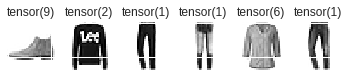

In [7]:
# visualize some images

args = Args(dataset='fashion_mnist')
_, _, _, test_dataset, _ = prepare_dataset(args)
images = test_dataset.test_data[:6]
print(images.shape)
labels = test_dataset.test_labels[:6]
fig, axes = plt.subplots(1,6)
for axis, img, lbl in zip(axes, images, labels):
    axis.imshow(img)
    axis.set_title(lbl)
    axis.set_yticklabels([])
    axis.set_xticklabels([])
plt.show()


In [157]:
def train(args, model, optimizer, epoch, total_minibatch_count,
        train_losses, train_accs):
    # Training for a full epoch
    num_iterations = int(length/args.batch_size)
    model.train()
    correct_count, total_loss, total_acc = 0., 0., 0.
    print_current = int(num_iterations/10)
    for batch_idx in range(num_iterations):
        
        data, target = generateBatch(args.batch_size)
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()

        # Forward prediction step
        output = model(data)
        test = torch.nn.MultiLabelSoftMarginLoss()
        loss = test(output, target)
        
        if(batch_idx % print_current == 0):
            print(str(batch_idx) + "/" + str(num_iterations))
            print(loss)
            print("OUTPUT")
            print(output[0:5])
            print("TARGET")
            print(target[0:5])
            print("^"*70)

        # Backpropagation step
        loss.backward()
        optimizer.step()

        # The batch has ended, determine the accuracy of the predicted outputs
        
        #pred = output.data.max(1)[1]  

        # target labels and predictions are categorical values from 0 to 9.
        #matches = target == pred
        #accuracy = matches.float().mean()
        #correct_count += matches.sum()

        if args.log_interval != 0 and \
                total_minibatch_count % args.log_interval == 0:

            train_losses.append(loss.data[0])
            #train_accs.append(accuracy.data[0])
            
        total_loss += loss.data
        #total_acc += accuracy.data
           

        total_minibatch_count += 1

    return total_minibatch_count

In [149]:
def test(args, model, epoch, total_minibatch_count,
        val_losses, val_accs):
    # Validation Testing
    model.eval()
    test_loss, correct = 0., 0.
    validation_thing = generateBatch(args.test_batch_size)
    with torch.no_grad():
        for current_sample in validation_thing:
            data,target = validation_thing[current_sample]
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test = torch.nn.MultiLabelSoftMarginLoss()
            test_loss += test(output, target, reduction='sum').data  # sum up batch loss
            #pred = output.data.max(1)[1]  # get the index of the max log-probability
            #correct += (target == pred).float().sum()

    test_loss /= len(test_loader.dataset)
    
    acc = correct / len(test_loader.dataset)

    val_losses.append(test_loss)
    #val_accs.append(acc)
    

    return acc

In [152]:
# Run the experiment
def run_experiment(args):

    total_minibatch_count = 0

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)


    epochs_to_run = args.epochs

    # Choose model
    # TODO add all the other models here if their parameter is specified
    if args.model == 'default' or args.model == 'P2Q7DefaultChannelsNet':
        model = Experiment1()
    elif args.model in globals():
        model = globals()[args.model]()
    else:
        raise ValueError('Unknown model type: ' + args.model)

    if args.cuda:
        model.cuda()

    # Choose optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    elif args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif args.optimizer == 'rms_prop':
        optimizer = optim.RMSprop(model.parameters())
    else:
        raise ValueError('Unsupported optimizer: ' + args.optimizer)

    # Run the primary training loop, starting with validation accuracy of 0
    val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(1, epochs_to_run + 1):
        print(str(epoch) + "/" + str(epochs_to_run + 1))
        
        # train for 1 epoch
        total_minibatch_count = train(args, model, optimizer,
                                    epoch, total_minibatch_count,
                                    train_losses, train_accs)
        # validate progress on test dataset
        val_acc = test(args, model, epoch, total_minibatch_count,
                       val_losses, val_accs)
        
    fig, axes = plt.subplots(1,4, figsize=(13,4))
    # plot the losses and acc
    plt.title(args.name)
    axes[0].plot(train_losses)
    axes[0].set_title("Loss")
    axes[1].plot(train_accs)
    axes[1].set_title("Acc")
    axes[2].plot(val_losses)
    axes[2].set_title("Val loss")
    axes[3].plot(val_accs)
    axes[3].set_title("Val Acc")
    
    # Write to csv file
    with open(os.path.join(run_path + 'train.csv'), 'w') as f:
        csvw = csv.writer(f, delimiter=',')
        for loss, acc in zip(train_losses, train_accs):
            csvw.writerow((loss, acc))

    # Predict and Test
    images, labels = next(iter(test_loader))
    if args.cuda:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    predicted = torch.max(output, 1)[1]
    fig, axes = plt.subplots(1,6)
    for i, (axis, img, lbl) in enumerate(zip(axes, images, predicted)):
        if i > 5:
            break
        img = img.permute(1,2,0).squeeze()
        axis.imshow(img)
        axis.set_title(lbl.data)
        axis.set_yticklabels([])
        axis.set_xticklabels([])
            
    if args.dataset == 'fashion_mnist' and val_acc > 0.92 and val_acc <= 1.0:
        print("Congratulations, you beat the Question 13 minimum of 92"
            "with ({:.2f}%) validation accuracy!".format(val_acc))

In [ ]:
run_experiment(Args(batch_size=25, epochs=100, optimizer='adam'))

1/101
0/4971
tensor(0.9511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
OUTPUT
tensor([[0.4838, 0.4696, 0.5149, 0.5099, 0.4913, 0.4790, 0.5029, 0.4952, 0.5012,
         0.5079, 0.4804, 0.5009, 0.5204, 0.4842, 0.5120, 0.4978, 0.5434, 0.5246,
         0.4917, 0.5053, 0.5163, 0.5234, 0.5514, 0.4966, 0.4944, 0.5471, 0.4969,
         0.4984],
        [0.4728, 0.5197, 0.4955, 0.5219, 0.5130, 0.4826, 0.4413, 0.5256, 0.4734,
         0.4729, 0.5070, 0.5177, 0.5137, 0.5115, 0.5223, 0.4514, 0.5361, 0.5240,
         0.5152, 0.4704, 0.5070, 0.5685, 0.5505, 0.4916, 0.5377, 0.5158, 0.5162,
         0.4592],
        [0.4979, 0.5176, 0.5020, 0.5084, 0.4598, 0.4730, 0.4449, 0.5302, 0.4920,
         0.4522, 0.4897, 0.5716, 0.5211, 0.5091, 0.5390, 0.5075, 0.4830, 0.5882,
         0.5245, 0.5026, 0.5542, 0.5396, 0.6039, 0.5347, 0.5122, 0.5425, 0.4893,
         0.5177],
        [0.5127, 0.4680, 0.4785, 0.5017, 0.4866, 0.4646, 0.4569, 0.5233, 0.5045,
         0.4494, 0.4531, 0.5725, 0.5084, 0.462

/home/login1/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
